In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import random
import torch
import os
import numpy as np
from torchvision.datasets import MNIST, SVHN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# from datasets import getPairedDataset
from model import EncoderA, EncoderB, DecoderA, DecoderB
from util import unpack_data, apply_poe
from torch.utils.data import Dataset
from sklearn.svm import LinearSVC
from scipy.ndimage import rotate

import sys

sys.path.append("../")
import probtorch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data = np.load(
    "../../data/mnist/mnist_rotated_360.npz"
)

X = torch.Tensor(data["original"][:50000]).to(device).reshape(-1, 1, 28, 28) #/ 255
Y = torch.Tensor(data["rotated"][:50000]).to(device).reshape(-1, 1, 28, 28)# / 255

# Y[Y > 1] = 1
# Y[Y < 0] = 0

X_test = (
    torch.Tensor(data["original"][60000:]).to(device).reshape(-1, 1, 28, 28)
    # / 255
)
Y_test = (
    torch.Tensor(data["rotated"][60000:]).to(device).reshape(-1, 1, 28, 28)
    # / 255 
)

# Y_val[Y_val > 1] = 1
# Y_val[Y_val < 0] = 0
batch_size = 100

In [5]:
class ViewDataset(Dataset):
    def __init__(self, v1, v2):
        self.v1 = torch.tensor(v1).float()
        self.v2 = torch.tensor(v2).float()
        self.data_len = v1.shape[0]

    def __getitem__(self, index):
        return self.v1[index], self.v2[index], index

    def __len__(self):
        return self.data_len

In [4]:
dataset = ViewDataset(X[:50000], Y[:50000])
val_dataset = ViewDataset(X_test, Y_test)

train_loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)

/tmp/ipykernel_3925473/650383694.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v1 = torch.tensor(v1).float()
/tmp/ipykernel_3925473/650383694.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v2 = torch.tensor(v2).float()


In [6]:
n_shared = 30
n_privateA = 0
n_privateB = 2
# batch_size = config["batch_size"]
epochs = 50
# lr = config["lr"]
beta1 = 10
beta2 = 10
run_id = 0
seed = 0
wseed = 0
lambda_text1 = 1.0
lambda_text2 = 1.0

In [7]:
encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

In [8]:
encA.load_state_dict(torch.load("../weights/mnist_svhn_cont/mnist_svhn_cont2-run_id5-privA00dim-privB02dim-sh30dim-lamb_text1_1.0-lamb_text2_1.0-beta11.0-beta21.0-seed0-bs100-wseed0-encA.rar"))
decA.load_state_dict(torch.load("../weights/mnist_svhn_cont/mnist_svhn_cont2-run_id5-privA00dim-privB02dim-sh30dim-lamb_text1_1.0-lamb_text2_1.0-beta11.0-beta21.0-seed0-bs100-wseed0-decA.rar"))
encB.load_state_dict(torch.load("../weights/mnist_svhn_cont/mnist_svhn_cont2-run_id5-privA00dim-privB02dim-sh30dim-lamb_text1_1.0-lamb_text2_1.0-beta11.0-beta21.0-seed0-bs100-wseed0-encB"))
decB.load_state_dict(torch.load("../weights/mnist_svhn_cont/mnist_svhn_cont2-run_id5-privA00dim-privB02dim-sh30dim-lamb_text1_1.0-lamb_text2_1.0-beta11.0-beta21.0-seed0-bs100-wseed0-decB"))

<All keys matched successfully>

In [8]:
shared = []

for i, batch in enumerate(train_loader):
    if batch[0].size()[0] == batch_size:
        images1 = batch[0]
        images2 = batch[1]

        # encode
        # print(images.sum())
        q = encA(images1, num_samples=1)
        q = encB(images2, num_samples=1, q=q)

        ## poe ##
        mu_poe, std_poe = apply_poe(
            True,
            q["sharedA"].dist.loc,
            q["sharedA"].dist.scale,
            q["sharedB"].dist.loc,
            q["sharedB"].dist.scale,
        )
        q.normal(mu_poe, std_poe, name="poe")

        shared.append(mu_poe.detach().cpu().numpy().squeeze())

shared = np.concatenate(shared, axis=0)


In [9]:
shared_test = []
private_test = []
recon_a = []
recon_b = []

for i, batch in enumerate(test_loader):
    if batch[0].size()[0] == batch_size:
        images1 = batch[0]
        images2 = batch[1]

        # encode
        # print(images.sum())
        q = encA(images1, num_samples=1)
        q = encB(images2, num_samples=1, q=q)

        ## poe ##
        mu_poe, std_poe = apply_poe(
            True,
            q["sharedA"].dist.loc,
            q["sharedA"].dist.scale,
            q["sharedB"].dist.loc,
            q["sharedB"].dist.scale,
        )
        # q.normal(mu_poe, std_poe, name="poe")
        private = q["privateB"].dist.loc

        shared_test.append(mu_poe.detach().cpu().numpy().squeeze())
        private_test.append(private.detach().cpu().numpy().squeeze())

        rec_a = decA.forward2(mu_poe)
        recon_a.append(rec_a.detach().cpu().numpy().squeeze())

        rec_b = decB.forward2(torch.cat((private, mu_poe), dim=-1))
        recon_b.append(rec_b.detach().cpu().numpy().squeeze())

shared_test = np.concatenate(shared_test, axis=0)
private_test = np.concatenate(private_test, axis=0)
recon_a = np.concatenate(recon_a, axis=0)
recon_b = np.concatenate(recon_b, axis=0)


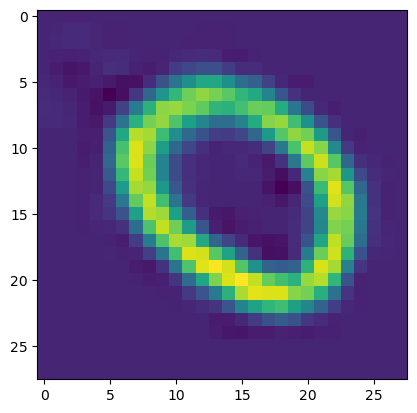

In [10]:
plt.imshow(recon_b[13].reshape(28, 28))

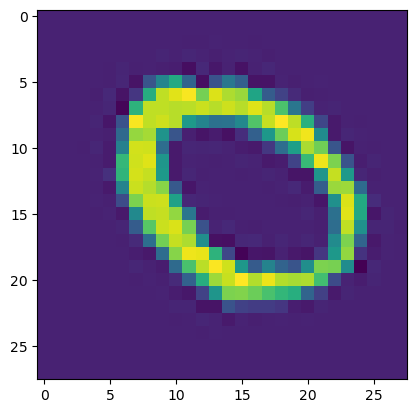

In [11]:
plt.imshow(data["rotated"][60013].reshape(28, 28))

In [41]:
tsne = TSNE(n_components=2, random_state=0)
shared_test_tsne = tsne.fit_transform(shared_test)

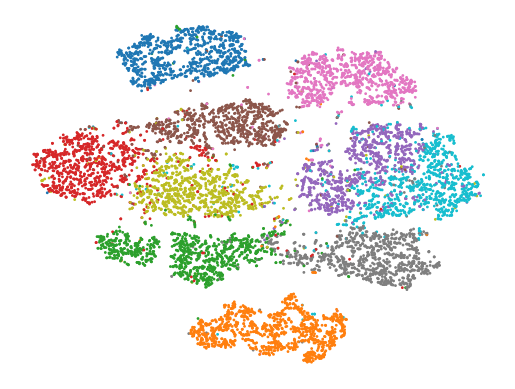

In [45]:
plt.scatter(shared_test_tsne[:, 0], shared_test_tsne[:, 1], cmap="tab10", s=1, c=np.array(data["labels"])[60000:])
plt.axis("off");
plt.savefig("../../figures/arxiv_figures/LEE_mnist360_tsne.png", transparent=True, dpi=300)

In [53]:
svm = LinearSVC(max_iter=10000)
svm.fit(shared, data["labels"][:50000].astype(int))
svm.score(shared_test, data["labels"][60000:].astype(int))

0.9128

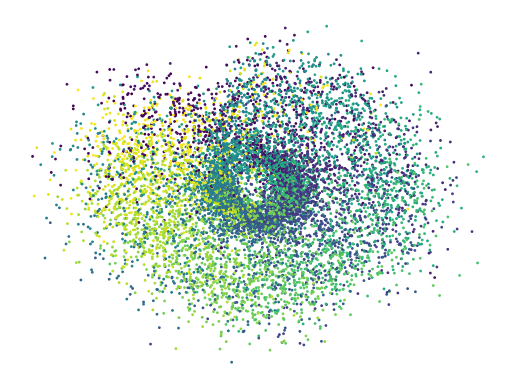

In [59]:
plt.scatter(private_test[:, 0], private_test[:, 1], s=1, c=np.array(data["angles"])[60000:]);
plt.axis("off")
plt.savefig("../../figures/arxiv_figures/Lee_mnist360_private.png", transparent=True, dpi=300)

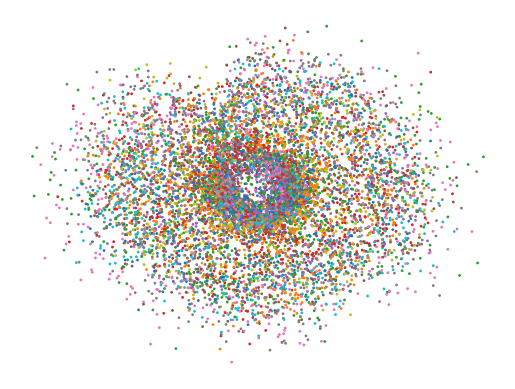

In [61]:
plt.scatter(private_test[:, 0], private_test[:, 1], s=1, c=np.array(data["labels"])[60000:], cmap="tab10");
plt.axis("off")
plt.savefig("../../figures/arxiv_figures/Lee_mnist360_private_colordigit.png", transparent=True, dpi=300)

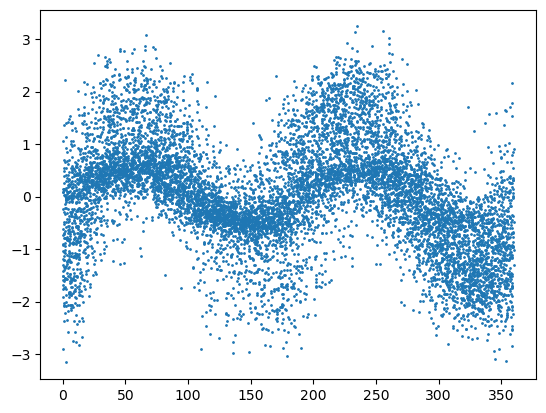

In [64]:
plt.scatter(data["angles"][60000:], private_test[:,0], s=1)

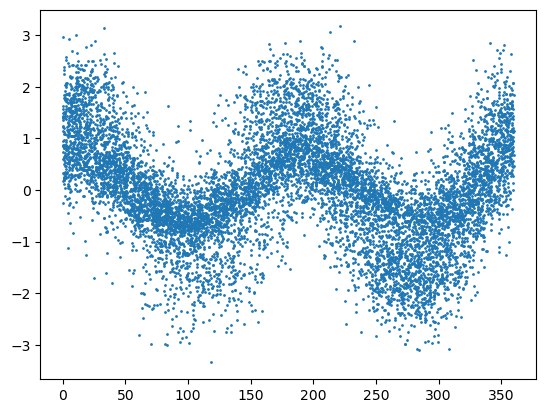

In [66]:
plt.scatter(data["angles"][60000:], private_test[:,1], s=1)

In [23]:
def rot_digit(m, angle=-1):
    """
    Returns the digit/image "m" by a random angle [-45,45]deg
    clips it to MNIST size
    and returns it flattened into (28*28,) shape
    """
    if angle < 0:
        angle=np.random.rand()*360 #will lead to ambiguities because "6" = "9"

    m = m.reshape((28,28))
    tmp = rotate(m, angle=angle)
    xs, ys = tmp.shape
    xs = int(xs/2)
    ys = int(ys/2)
    rot_m = tmp[xs-14:xs+14,ys-14:ys+14]
    return rot_m.reshape((28*28,)), angle

In [84]:
def find_offset(digit, reference, model):
    rot = np.zeros((360, 28*28))

    for i in range(360):
        rot[i] = rot_digit(digit, angle=i)[0]

    rot = torch.Tensor(rot).reshape(-1,28,28).unsqueeze(1).to(device)
    rot[rot > 1] = 1
    rot[rot < 0] = 0

    # z_y = model.target_enc(rot).detach().cpu().numpy().squeeze()
    q = model(rot, num_samples=1)
    z_y = q["privateB"].dist.loc.detach().cpu().numpy().squeeze()

    coarse_shift = np.arange(0, 360, 20)
    inner_prods = np.zeros_like(coarse_shift)

    for i, shift in enumerate(coarse_shift):
        shifted = np.roll(z_y[:,0], shift)
        inner_prods[i] = np.dot(shifted-18, reference-18)

    best_coarse = coarse_shift[np.argmax(inner_prods)]

    fine_shift = np.arange(best_coarse-10, best_coarse+10)
    inner_prods = np.zeros_like(fine_shift)

    for i, shift in enumerate(fine_shift):
        shifted = np.roll(z_y[:,0], shift)
        inner_prods[i] = np.dot(shifted-18, reference-18)

    best_fine = fine_shift[np.argmax(inner_prods)]

    return best_fine
    

In [85]:
base_rot = np.zeros((360, 28*28))
for i in range(360):
    base_rot[i] = rot_digit(X_test[-10000:][0].detach().cpu().numpy(), angle=i)[0]

base_rot = torch.Tensor(base_rot).reshape(-1,28,28).unsqueeze(1).to(device)

base_rot[base_rot > 1] = 1
base_rot[base_rot < 0] = 0

q = encB(base_rot, num_samples=1)
z_y = q["privateB"].dist.loc.detach().cpu().numpy().squeeze()

In [86]:
shifts = np.zeros(5000)

for i in range(5000):
    print(i, end="\r")
    shifts[i] = find_offset(X_test[-10000:][i].detach().cpu().numpy(), z_y[:,0], encB)

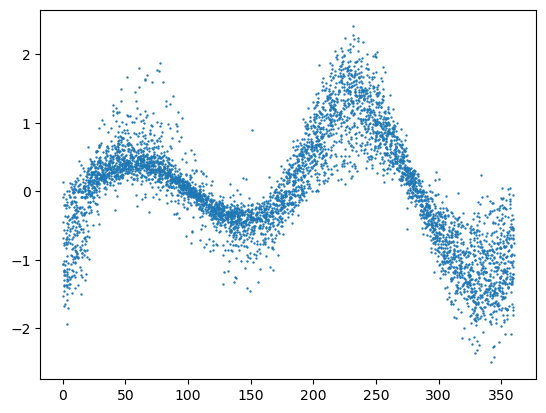

In [89]:
plt.scatter((data["angles"][-10000:][:5000]+shifts)% 360, private_test[:5000, 0]/np.var(z_y[:,0]), s=0.5)
plt.savefig("../../figures/arxiv_figures/Lee_aligned_latent0_vs_theta.png", transparent=True, dpi=300)

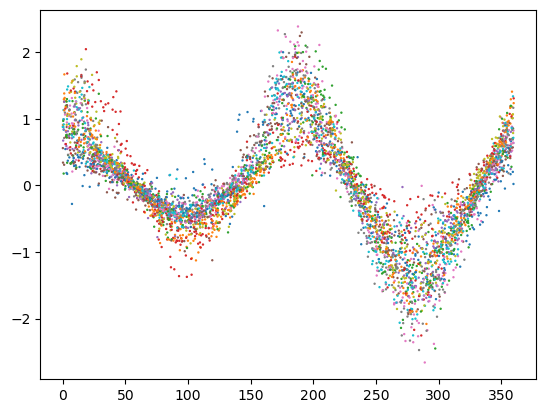

In [91]:
plt.scatter((data["angles"][-10000:][:5000]+shifts)% 360, private_test[:5000, 1]/np.var(z_y[:,0]), s=0.5,)
# plt.savefig("../../figures/arxiv_figures/Lee_aligned_latent1_vs_theta.png", transparent=True, dpi=300)

In [92]:
window_vars = []

shifted_angles = (data["angles"][-10000:][:5000]+shifts) % 360
full_var = np.var(private_test[:5000], axis=0)
width = 5

for i in range(360):
    window = private_test[:5000][(shifted_angles > i) & (shifted_angles < i+width)]
    var = np.var(window, axis=0)/full_var
    window_vars.append(var.mean())

In [96]:
max(window_vars)

0.3419602

In [93]:
np.array(window_vars).mean()

0.16294949

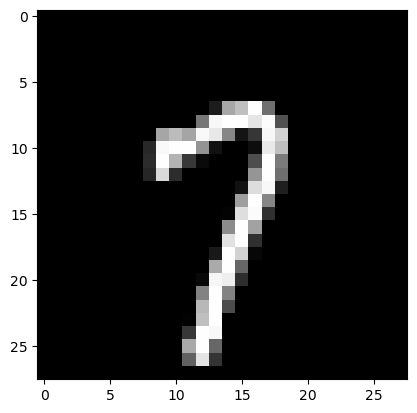

In [100]:
plt.imshow(data["original"][-10000:][2463].reshape(28, 28), cmap="gray")

In [14]:
digit_source = torch.Tensor(np.tile(data["original"][-10000:][2463].reshape(-1,1,28,28), [5,1,1,1])).to(device)

In [56]:
rot_angles = [36, 108, 180, 252, 324]
rot_inds = [264, 3910, 2463, 4756, 7293]
angle_sources = np.zeros((5,784))
# angle_sources = []

# for angle in rot_angles:
#     ind = 0
#     argsort = np.argsort(np.abs(data["angles"][-10000:] -angle))
#     while data["labels"][-10000:][argsort[ind]] == 5:
#         ind += 1

#     angle_sources.append(argsort[ind])

for i, angle in enumerate(rot_angles):
    angle_sources[i] = rot_digit(data["original"][-10000:][rot_inds[i]], angle=angle)[0]

# angle_sources = []


In [58]:
angle_sources = torch.Tensor(angle_sources).reshape(-1,1,28,28).to(device)

In [50]:

# for angle in rot_angles:
#     angle_sources.append(np.argsort(np.abs(data["angles"][-10000:] -angle ))[0])



In [54]:
angle_sources

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.83321320e-27, -1.18978146e-25, -1.80591077e-26, ...,
        -3.01112213e-26,  8.20429285e-27,  3.75639655e-27],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [55]:
# angle_sources = torch.Tensor(data["rotated"][-10000:][angle_sources].reshape(-1, 1, 28, 28)).to(device)

IndexError: arrays used as indices must be of integer (or boolean) type

In [35]:
angle_sources.shape

torch.Size([5, 1, 28, 28])

In [59]:
q = encA(digit_source, num_samples=1)
q = encB(angle_sources, num_samples=1, q=q)

In [60]:
shared_cross = q["sharedA"].dist.loc
private_cross = q["privateB"].dist.loc

In [61]:
cross_rec = decB.forward2(torch.cat((private_cross, shared_cross), dim=-1))

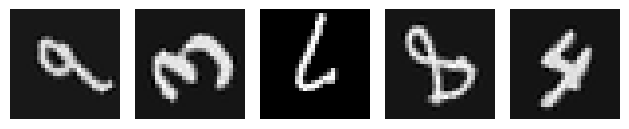

In [62]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(angle_sources[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray")
    # plt.savefig(f"../../figures/arxiv_figures/Lee_cross_rec_{i}.png", transparent=True, dpi=300)
    plt.axis("off");

plt.tight_layout()


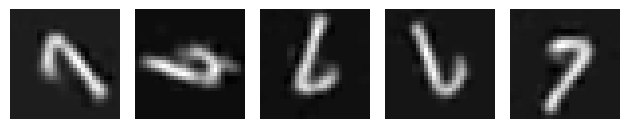

In [64]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cross_rec[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray")
    plt.axis("off");

plt.tight_layout()
plt.savefig(f"../../figures/arxiv_figures/Lee_cross_rec.svg", transparent=True, dpi=300)


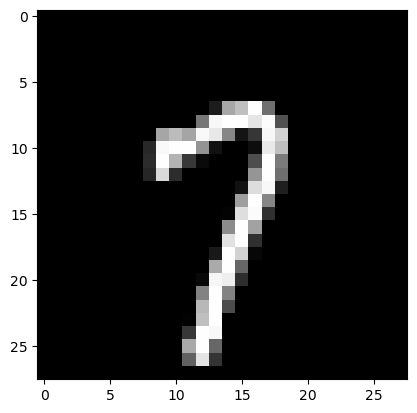

In [156]:
plt.imshow(data["original"][-10000:][2463].reshape(28,28), cmap="gray")